In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

import sunpy
from sunpy.map import Map
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.coordinates.frames import Helioprojective, HeliographicStonyhurst

import matplotlib.pyplot as plt

import numpy as np

from aiapy.calibrate import normalize_exposure, register, update_pointing

import copy

In [6]:
with fits.open("20220407.180754.ucomp.1074.l1.p3.fts") as hdul:
    hdul.info()
    int_1074 = hdul[2].data[0, :, :]
    header_1074 = hdul[0].header
    ext_header = hdul[2].header
print(repr(ext_header))

Filename: 20220407.180754.ucomp.1074.l1.p3.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     185   ()      
  1  Corona Stokes IQUV [1074.59 nm]    1 ImageHDU        37   (1280, 1024, 4)   float32   
  2  Corona Stokes IQUV [1074.70 nm]    1 ImageHDU        37   (1280, 1024, 4)   float32   
  3  Corona Stokes IQUV [1074.81 nm]    1 ImageHDU        37   (1280, 1024, 4)   float32   
  4  Background I [1074.59 nm]    1 ImageHDU        27   (1280, 1024)   float32   
  5  Background I [1074.70 nm]    1 ImageHDU        27   (1280, 1024)   float32   
  6  Background I [1074.81 nm]    1 ImageHDU        27   (1280, 1024)   float32   
XTENSION= 'IMAGE   '           / extension type                                 
BITPIX  =                  -32 / bits per data value                            
NAXIS   =                    3 / number of axes                                 
NAXIS1  =                 1280 / [pixels] width                         

In [37]:
ucomp_map_0 = Map(int_1074, header_1074)

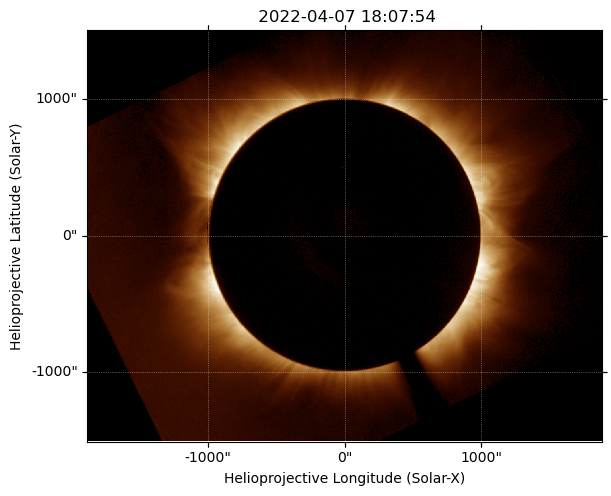

In [38]:
fig = plt.figure(figsize=(6,6), constrained_layout=True)

norm_1074 = ImageNormalize(int_1074, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=ucomp_map_0)
ucomp_map_0.plot(axes=ax, cmap='sdoaia193', norm=norm_1074)

In [39]:
# From:
#
# https://sunpy-tutorial.readthedocs.io/en/latest/notebooks/AIA-Example-1.html
#
# but it doesn't work?
#
# %matplotlib inline
# from matplotlib import pyplot as plt
#
# from sunpy.instr.aia import aiaprep
# from sunpy.net import Fido, attrs as a
#
# from astropy.coordinates import SkyCoord
# from astropy import units as u
#
# import warnings
# warnings.filterwarnings("ignore")

aia_filename = "aia.lev1_euv_12s.2022-04-07T120706Z.193.image_lev1.fits"
aia_map = register(update_pointing(Map(aia_filename)))

# result = Fido.search(a.Time('2014-09-19T05:59:00', '2014-09-19T06:01:00'),
#                      a.Instrument("aia"), a.Wavelength(171*u.angstrom),
#                      a.vso.Sample(12*u.second))

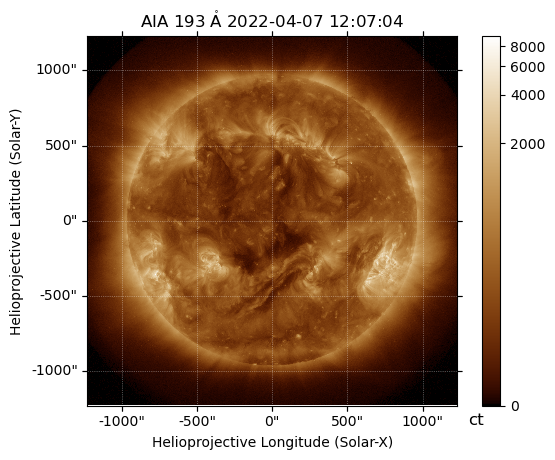

In [30]:
aia_map.peek(vmin=0)

In [15]:
# aia_map_reproject = aia_map.reproject_to(WCS(header_1074))

Astropy's FITS reader doesn't seem to want to inherit from the primary header when reading the extension header, even though `INHERIT` is set to 'T'. So we read the primary header above, and now change the `NAXIS` keywords to match the extension data.

In [40]:
header_1074_naxis = copy.deepcopy(header_1074)
header_1074_naxis['NAXIS1'] = hdul[1].header['NAXIS1']
header_1074_naxis['NAXIS2'] = hdul[1].header['NAXIS2']
del header_1074_naxis['NAXIS']

In [41]:
aia_map_reproject = aia_map.reproject_to(WCS(header_1074_naxis))

In [23]:
#aia_map_reproject = aia_map.reproject_to(ucomp_map_0.wcs)

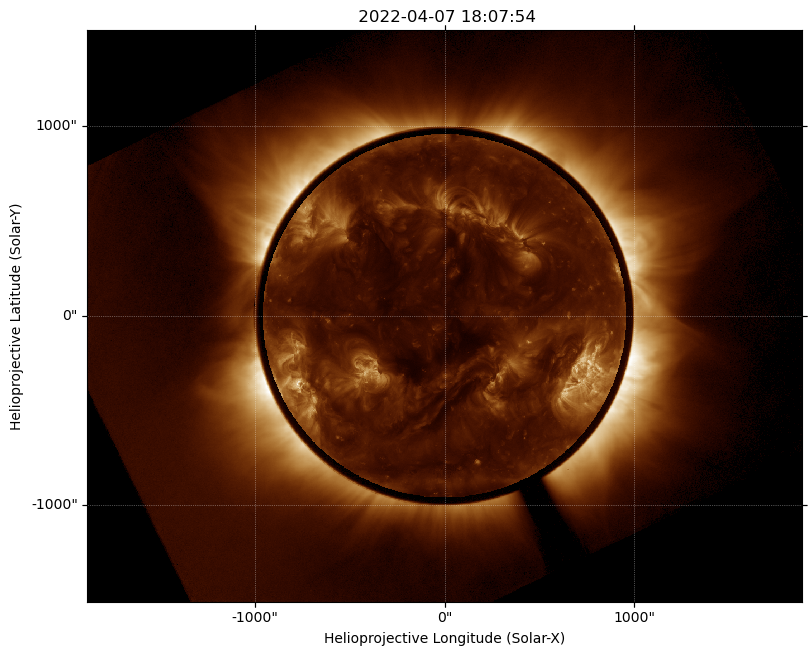

In [45]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)

norm_aia = ImageNormalize(aia_map_reproject.data, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=ucomp_map_0)

ucomp_map_0.plot(axes=ax, cmap='sdoaia193', norm=norm_1074)

aia_map_reproject.plot(axes=ax, cmap='sdoaia193', norm=norm_aia)

# see https://docs.sunpy.org/en/latest/generated/gallery/map_transformations/reprojection_different_observers.html
# concerning warning below